<a href="https://colab.research.google.com/github/rishubhkhurana/nlp/blob/main/cnn/Seq2SeqCNNAttn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Book Keeping

In [1]:
!python -m spacy download en > /dev/null 2>&1
!python -m spacy download de > /dev/null 2>&1

## Importing Libs

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from torchtext.data import Field
from torchtext.datasets import Multi30k
import torchtext
import random, time, math
from torchtext.data import BucketIterator
import matplotlib.ticker as ticker

## SEED everything

In [3]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Dataset/ Dataloader

In [4]:
spacy_en = spacy.load('en')
spacy_de = spacy.load('de')

In [5]:
def tokenize_src(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]
def tokenize_trg(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [6]:
SRC = Field(tokenize = tokenize_src, init_token = '<sos>', 
            eos_token = '<eos>', lower = True,
            batch_first = True)
TRG = Field(tokenize = tokenize_trg, init_token = '<sos>',
            eos_token = '<eos>', lower = True, batch_first = True)

In [7]:
train_data, valid_data, test_data = Multi30k.splits(fields = (SRC, TRG), exts = ('.de', '.en'))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 542kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 165kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 162kB/s]


In [8]:

len(train_data), len(valid_data), len(test_data)

(29000, 1014, 1000)

In [9]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size = 128, device = device)

## Model

In [29]:
class CNNEncoder(nn.Module):
    """
    Class to encode the source language word sequence. 
    src words --> word embedding + position embedding --> linear layer --> CNN layers --> linear layer --> encoded
    """
    def __init__(self, 
                 vocab_size,
                 embed_dims,
                 hidden_dims,
                 ncnn_layers,
                 max_length = 100,
                 kernel_size = 3,
                 dropout = 0.1,
                 device = 'cuda'
                 ):
        super().__init__()
        # store all required variables
        self.embed_dims = embed_dims
        self.hidden_dims = hidden_dims
        self.device = device
        # define a scale variable which would be used when we add two latent variables
        self.scale = torch.sqrt(torch.tensor([0.5])).float().to(device)
        # add the token embedding 
        self.token_embedder = nn.Embedding(vocab_size, embed_dims)
        # add position embedding, max length here refers to the source text's largest sequence length
        self.position_embedder = nn.Embedding(max_length, embed_dims)
        # add projection layer from embedding to hidden dims for conv layers
        self.embed2hidden = nn.Linear(embed_dims, hidden_dims)
        # add projection layer back from hidden to embedding after conv layers
        self.hidden2embed = nn.Linear(hidden_dims, embed_dims)
        # add the conv layers 
        # for conv layers, hidden dims are the number of input channels and we need to add 2*hidden dims 
        # we apply GLU activation by dividing the 2*hidden dims
        # create an empy list to hold modules
        self.convlayers = nn.ModuleList()
        for _ in range(ncnn_layers):
            self.convlayers.append(nn.Conv1d(in_channels = hidden_dims, 
                                             out_channels = 2*hidden_dims,
                                             kernel_size = kernel_size, 
                                             stride = 1,
                                             padding = kernel_size//2))
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, src):
        # get the src seq length
        # src: [Batch size, src length]
        srclen = src.shape[1]
        bs = src.shape[0]
        # pass through the embedding layers
        tok_embedded = self.dropout(self.token_embedder(src))
        # tok_embedded : [batch size, src length, embed dims]
        # pass through the position layers
        positions = torch.arange(srclen).long().unsqueeze(0).repeat(bs, 1).to(self.device)
        # positions: [bs, srclen]
        pos_embedded = self.dropout(self.position_embedder(positions))
        # pos_embedded: [bs, srclen, embed_dims]
        # add the embeddings
        combined_embedded = (pos_embedded+tok_embedded)
        # combined_embedded: [bs, srclen, embed_dims]
        # pass through the porjection layer prior to conv layers
        conv_input = self.embed2hidden(combined_embedded)
        # conv_input: [batch size, src length, hidden_dims]
        # for conv layer, we need hidden dims as input channels and in pytorch, channels appear before the length/spatial dimen sions
        conv_input = conv_input.permute(0, 2, 1)
        # pass the conv input through the conv layers one by one
        for clayer in self.convlayers:
            conv_output = clayer(conv_input)
            # conv_output: [batch size, 2*hidden dims, srclen]
            conv_output = F.glu(conv_output, dim = 1)
            # conv_output: [batch size, hidden_dims, srclen]
            conv_output = self.dropout(conv_output)
            # add residual connection 
            conv_output = (conv_output + conv_input)*self.scale
            # store conv_output as conv input for next layer
            conv_input = conv_output
        # permute the dimensions
        conv_output = conv_output.permute(0, 2, 1)
        # conv_output: [batch size, srclen, hidden dims]
        # pass the conv output through projection layer for conv output
        conv_output = self.hidden2embed(conv_output)
        # conv_output: [batch size, srclen, embed dims]
        # add the original combined embedding as residual connection to conv output
        combined = (combined_embedded + conv_output)*self.scale
        
        return combined, conv_output

            


In [30]:
class CNNDecoderWithAttention(nn.Module):

    def __init__(self,
                 vocab_size,
                 embed_dims,
                 hidden_dims,
                 ncnn_layers,
                 pad_idx,
                 max_length=100,
                 kernel_size = 3,
                 dropout = 0.1,
                 device = 'cuda'
                 ):
        super().__init__()
        # store the variables
        self.kernel_size = kernel_size
        self.scale = torch.sqrt(torch.tensor([0.5])).float().to(device)
        self.embed_dims = embed_dims
        self.hidden_dims = hidden_dims
        self.pad_idx = pad_idx
        self.device = device
        # add the embedding layer for token
        self.tok_embedder = nn.Embedding(vocab_size, embed_dims)
        # add the embedding layer for positions
        self.pos_embedder = nn.Embedding(max_length, embed_dims)
        # add a projection layer before cnn layers
        self.embed2hidden = nn.Linear(embed_dims, hidden_dims)
        # add a projection layer for cnn output 
        self.hidden2embed = nn.Linear(hidden_dims, embed_dims)
        # add an output layer 
        self.outlayer = nn.Linear(embed_dims, vocab_size)
        # create an empty module list for cnn layers
        self.convlayers = nn.ModuleList()
        # add specified number of cnnlayers
        for _ in range(ncnn_layers):
            self.convlayers.append(nn.Conv1d(in_channels = hidden_dims,
                                        out_channels = 2*hidden_dims, 
                                        kernel_size = kernel_size,
                                        padding = 0))
        # add dropout layer
        self.dropout = nn.Dropout(dropout)
        # add attention projection layers
        self.attnhid2embed = nn.Linear(hidden_dims, embed_dims)
        self.attnembed2hid = nn.Linear(embed_dims, hidden_dims)


    def get_attention(self, combined_embedding, conv_output, encoder_conv_output, encoder_combined):
        # encoder_conv_output: [batch size, srclen, embed_dims]
        # encoder_combined: [batch size, srclen, embed_dims]
        # combined_embedding: [batch size, trglen, embed_dims]
        # conv_output: [batch size, hidden_dims, trglen]
        # assumption --> embed_dims for encoder are same as embed_dims for decoder
        # project the conv_output to embed dims
        conv_attention = self.attnhid2embed(conv_output.permute(0, 2, 1))

        # add the target embedding to conv_attention
        combined_attention = (combined_embedding + conv_attention)*self.scale

        # compute the attention raw scores with encoder 
        attention_energy = torch.matmul(combined_attention, encoder_conv_output.permute(0, 2, 1))
        # attention_energy: [bs, trglen, srclen]

        # apply softmax to get the attention probabilities
        attention = F.softmax(attention_energy, dim = 2)

        # multy the attention probabilties with encoder combined to get then attention value vector 
        attention_values = torch.matmul(attention, encoder_combined)
        # project the attention values back to hidden dims
        # attention_values: [bs, trglen, embed_dims]
        attention_values = self.attnembed2hid(attention_values).permute(0, 2, 1)
        # attention_values: [bs, hidden_dims, trglen]

        attention_combined = (conv_output + attention_values)*self.scale
        # attention_combined: [bs, trglen, hidden_dims]

        return attention, attention_combined
    
    def forward(self, trg, encoder_combined, encoder_conv_output):

        # trg: [bs, trglen]
        trglen = trg.shape[1]
        bs = trg.shape[0]

        # get the token embedding
        tok_embedding = self.dropout(self.tok_embedder(trg))
        # get position embedding
        positions = torch.arange(trglen).long().unsqueeze(0).repeat(bs, 1).to(self.device)

        pos_embedding = self.dropout(self.pos_embedder(positions))
        # combined embedding
        combined_embedding = tok_embedding + pos_embedding 
        # combined_embedding: [bs, trglen, embed_dims]

        # project the embedding before passing through conv layers
        conv_input = self.embed2hidden(combined_embedding)
        # conv_input: [bs, trglen, hidden_dims]
        conv_input = conv_input.permute(0, 2, 1)
        # conv_input: [bs, hidden_dims, trglen]

        # pass through conv layers
        for clayer in self.convlayers:
            padding = torch.zeros(bs, self.hidden_dims, self.kernel_size-1).fill_(self.pad_idx).to(self.device)
            padded_conv_input = torch.cat([padding, conv_input], dim = 2)
            # padded_conv_input: [bs, hidden_dims, trglen+self.kernel_size-1]
            conv_output = clayer(padded_conv_input)
            # conv_output: [bs, 2*hidden_dims, trglen]
            conv_output = F.glu(conv_output, dim = 1)
            # conv_output: [bs, hidden_dims, trglen]
            attention, conv_output = self.get_attention(combined_embedding, conv_output, encoder_combined, encoder_conv_output)
            # attention: [bs, trglen, srclen]
            # conv_output: [bs, hidden_dims, trglen]
            conv_output = (conv_input + conv_output)*self.scale
            conv_input = conv_output
        
        # conv_output: [bs, hidden_dims, trglen]
        conv_output = conv_output.permute(0, 2, 1)
        # conv_output: [bs, trglen, hidden_dims]
        # pass through the re-projection layer
        conv_output = self.hidden2embed(conv_output)
        # conv_output: [bs, trglen, embed_dims]

        # compute the output raw scores 
        classifier_output = self.outlayer(conv_output)
        # classifier_output: [bs, trglen, vocab_size]

        return classifier_output, attention

In [31]:
class CNNSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        # register encoder
        self.encoder = encoder
        # register decoder
        self.decoder = decoder
    
    def forward(self, src, trg):
        # src: [bs, srclen]
        # trg: [bs, trglen]
        encoder_combined, encoder_conv_output = self.encoder(src)
        # encoder_combined: [bs, srclen, embed_dims]
        # encoder_conv_output: [bs, srclen, embed_dims]
        output, attention = self.decoder(trg, encoder_combined, encoder_conv_output)
        return output, attention

## Training Model

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:


INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

 
enc = CNNEncoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, dropout = ENC_DROPOUT, device = device, max_length = 500)
dec = CNNDecoderWithAttention(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, dropout = DEC_DROPOUT, pad_idx = TRG_PAD_IDX, device = device, max_length = 500)

model = CNNSeq2Seq(enc, dec).to(device)

In [34]:




#model

In [35]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,556,485 trainable parameters


In [36]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [37]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        #print(i)
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [38]:

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [40]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [41]:
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss} | Train PPL: {math.exp(train_loss)}')
    print(f'\t Val. Loss: {valid_loss} |  Val. PPL: {math.exp(valid_loss)}')

Epoch: 01 | Time: 1m 5s
	Train Loss: 3.2635947261087694 | Train PPL: 26.143346602445767
	 Val. Loss: 2.902229905128479 |  Val. PPL: 18.214717208271967
Epoch: 02 | Time: 1m 4s
	Train Loss: 2.9737417015210124 | Train PPL: 19.564989158227228
	 Val. Loss: 2.8036914467811584 |  Val. PPL: 16.505463491269143
Epoch: 03 | Time: 1m 4s
	Train Loss: 2.818161757506988 | Train PPL: 16.746039080600234
	 Val. Loss: 2.6884103417396545 |  Val. PPL: 14.708276193838868
Epoch: 04 | Time: 1m 4s
	Train Loss: 2.7161029550997697 | Train PPL: 15.121278969437183
	 Val. Loss: 2.6530802249908447 |  Val. PPL: 14.197703483171423
Epoch: 05 | Time: 1m 4s
	Train Loss: 2.6431899438345483 | Train PPL: 14.057976313426328
	 Val. Loss: 2.6159967482089996 |  Val. PPL: 13.68084594283426
Epoch: 06 | Time: 1m 4s
	Train Loss: 2.6200098623788306 | Train PPL: 13.735859052655448
	 Val. Loss: 2.678875654935837 |  Val. PPL: 14.568703833655249
Epoch: 07 | Time: 1m 4s
	Train Loss: 2.609003849491674 | Train PPL: 13.585510895448998
	 Val

OverflowError: ignored

In [42]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.623 | Test PPL:  13.775 |


In [43]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [44]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [45]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


In [46]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'young', 'girl', 'climbs', 'a', 'rock', 'into', 'a', 'small', 'bowl', '.', '<eos>']


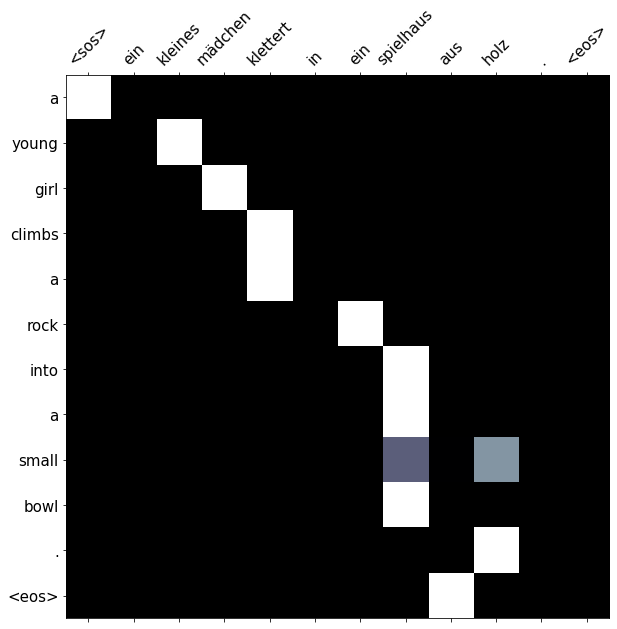

In [49]:
display_attention(src, translation, attention)

In [50]:
example_idx = 2

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'junge', 'mit', 'kopfhörern', 'sitzt', 'auf', 'den', 'schultern', 'einer', 'frau', '.']
trg = ['a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.']


In [51]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'boy', 'wearing', 'jeans', 'is', 'sitting', 'on', 'a', 'cellphone', 'in', 'a', 'chair', '.', '<eos>']


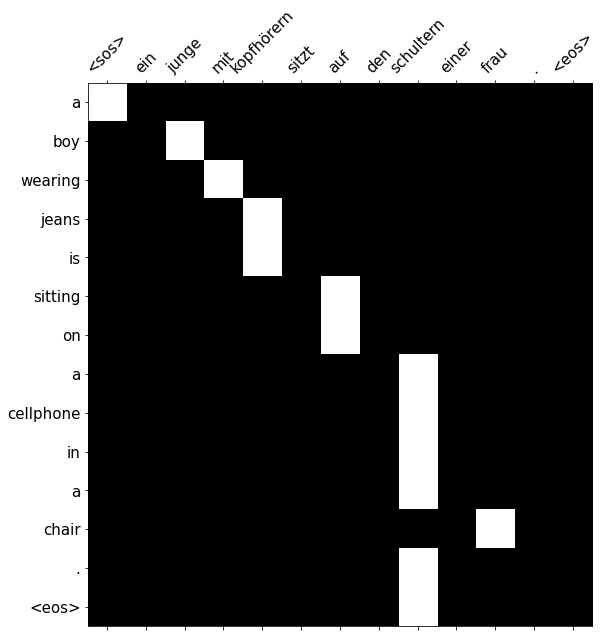

In [52]:
display_attention(src, translation, attention)